## Vizualising RAPSDs for all synthetic car types

In [ ]:
!pip install -q deeplake
!pip install -q pysteps
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is 

In [ ]:
import os
import time
import copy
import itertools
import shutil
import zipfile
import random
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from scipy.signal import welch
from scipy.interpolate import interp1d
from skimage import io, color
from IPython.display import Audio, display
import tensorflow_datasets as tfds
import librosa
from pysteps.utils import spectral
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from datasets import load_dataset, concatenate_datasets

# Configure matplotlib for animations
rc('animation', html='jshtml')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Checking the data and paths

In [ ]:
# Defining path for the zip folder of synthetic images
stanford_cars_synthetic_path = '/content/drive/My Drive/Colab Notebooks/Stanford_Cars/stanford-cars-synthetic-classwise-16.zip'

# Define path we store it in
extraction_path = '/content/stanford-cars-synthetic'

# Extract the zip file to the specified path
with zipfile.ZipFile(stanford_cars_synthetic_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to {extraction_path}")

Files extracted to /content/stanford-cars-synthetic


In [ ]:
all_cars_path = '/content/stanford-cars-synthetic/stanford-cars-synthetic-classwise-16/synthetic_16'

#for car_folder in sorted(os.listdir(all_cars_path)):
#  print(car_folder)

print("We have", len(sorted(os.listdir(all_cars_path))), "models of cars")

We have 197 models of cars


## **Analysis on 2920 the synthetic car pictures - RAPSDs, residuals and power law exponents**

In [ ]:
try:
    # Load the dataset
    dataset_synth_cars = load_dataset(all_cars_path, split="train")
    print("Dataset loaded successfully.")

    # Convert the dataset to a list if it isn't already
    dataset_synth_cars = list(dataset_synth_cars)

    # Shuffle the dataset
    random.seed(42)  # Set seed for reproducibility
    random.shuffle(dataset_synth_cars)

    # Split into train and test sets
    test_set_size = 200
    test_set_fake = dataset_synth_cars[:test_set_size]  # First 200 images
    train_set_fake = dataset_synth_cars[test_set_size:] # Remaining images

    # Print sizes
    print(f"Training set size: {len(train_set_fake)}")
    print(f"Test set size: {len(test_set_fake)}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Resolving data files:   0%|          | 0/3120 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.
Training set size: 2920
Test set size: 200


In [ ]:
def resize_and_crop(image, smallest_side):
    height, width, num_channels = image.shape

    # Resize.
    if height <= width:
        new_height = smallest_side
        new_width = int(width * (new_height / height))
    else:
        new_width = smallest_side
        new_height = int(height * (new_width / width))

    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Centre crop.
    offset_h = (new_height - smallest_side) // 2
    offset_w = (new_width - smallest_side) // 2

    return image[offset_h:offset_h + smallest_side, offset_w:offset_w + smallest_side, :]

In [ ]:
image_size = 320
num_examples_synth = len(train_set_fake)
images_synth = []
for example in itertools.islice(train_set_fake, num_examples_synth):
  img = example['image']
  arr = np.array(img)
  arr = resize_and_crop(arr, image_size)
  images_synth.append(arr)
images_synth = np.array(images_synth)

In [ ]:
images_synth = (images_synth.astype(np.float32) / 255.0) * 2 - 1  # Scale and shift to [-1, 1].

In [ ]:
def calc_mean_log_rapsd(x):
  spectra = []
  for k in range(num_examples_synth):
    rapsd, frequencies = spectral.rapsd(x[k, ...], fft_method=np.fft, return_freq=True)
    spectra.append(rapsd)

  mean_log_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_rapsd, frequencies

0.14484882911095082


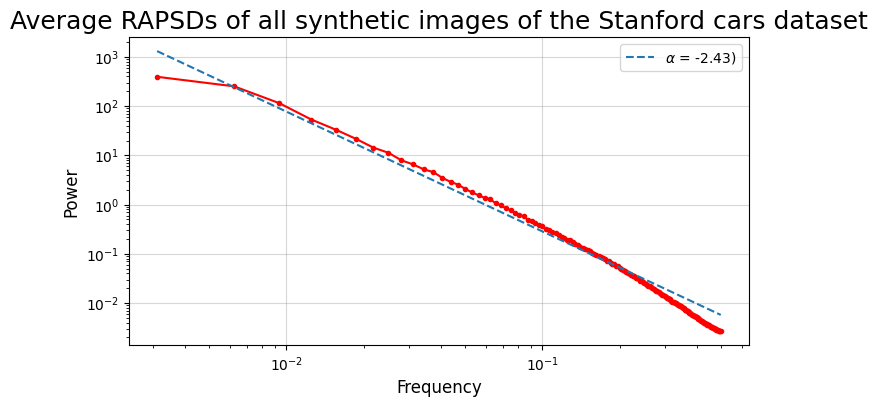

In [ ]:
# Plotting the log RAPSDs
mean_log_rapsd_synth, frequencies_synth = calc_mean_log_rapsd(images_synth[..., 1])

# Getting the alpha exponent of powerlaw
log_frequencies_synth = np.log(frequencies_synth[1:])
equally_spaced_log_frequencies_synth = np.linspace(log_frequencies_synth[0], log_frequencies_synth[-1], 1000)
interpolated_rapsd_synth = np.interp(equally_spaced_log_frequencies_synth, log_frequencies_synth, mean_log_rapsd_synth[1:])

m_synth, b_synth = np.polyfit(equally_spaced_log_frequencies_synth, interpolated_rapsd_synth, 1)
linear_fit_synth = m_synth * equally_spaced_log_frequencies_synth + b_synth

# Residuals
mse_synth = np.mean((linear_fit_synth - interpolated_rapsd_synth)**2)
print(mse_synth)
residuals_mse_synth = np.sqrt(mse_synth)

# Plotting

plt.figure(figsize=(8, 4))
plt.title("Average RAPSDs of all synthetic images of the Stanford cars dataset", fontsize = 18)
plt.plot(frequencies_synth[1:], np.exp(mean_log_rapsd_synth)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies_synth), np.exp(linear_fit_synth), label=f'$\\alpha$ = {m_synth:.2f})', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Power', fontsize = 12);

<ipython-input-12-a19cc6f2ab30>:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-0.001, 0.52)


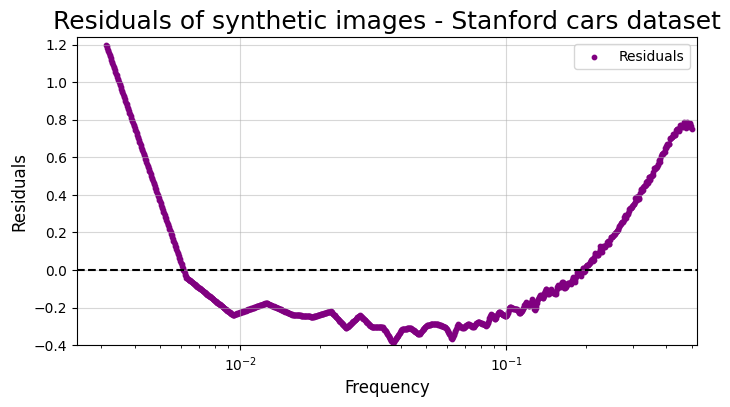

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 4))
residuals_synth = linear_fit_synth - interpolated_rapsd_synth
plt.scatter(np.exp(equally_spaced_log_frequencies_synth), residuals_synth, color='purple', label="Residuals", s=10)
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Residuals', fontsize = 12)
plt.xlim(-0.001, 0.52)
plt.ylim(-0.4,1.24)
plt.title("Residuals of synthetic images - Stanford cars dataset", fontsize = 18)

plt.grid(alpha = 0.5)
plt.legend()
plt.show()

## **Analysis on 2920 the real car pictures - RAPSDs, residuals and power law exponents**

In [ ]:
# Defining path for the zip folder of real images
stanford_cars_real_path = '/content/drive/My Drive/Colab Notebooks/Stanford_Cars/stanford-cars-real-train-fewshot.zip'

# Define path we store it in
extraction_path = '/content/stanford-cars-real'

# Extract the zip file to the specified path
with zipfile.ZipFile(stanford_cars_real_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to {extraction_path}")

NameError: name 'zipfile' is not defined

In [ ]:
all_real_cars_path = '/content/stanford-cars-real/stanford-cars-real-train-fewshot'

#for car_folder in sorted(os.listdir(all_cars_path)):
#  print(car_folder)

print("We have", len(sorted(os.listdir(all_real_cars_path))), "models of cars")

NameError: name 'os' is not defined

In [ ]:
import random
try:
    # Load the dataset
    dataset_real_cars = load_dataset(all_real_cars_path, split="train")
    print("Dataset loaded successfully.")

    # Convert the dataset to a list
    dataset_real_cars = list(dataset_real_cars)

    # Shuffle the dataset
    random.seed(42)  # Set seed
    random.shuffle(dataset_real_cars)

    # Split into train and test sets
    test_set_size = 200
    test_set_real = dataset_real_cars[:test_set_size]  # First 200 images
    train_set_real = dataset_real_cars[test_set_size:] # Remaining images

    # Print sizes
    print(f"Training set size: {len(train_set)}")
    print(f"Test set size: {len(test_set)}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Error loading dataset: name 'load_dataset' is not defined


In [ ]:
# Function to resize and crop images
def resize_and_crop(image, image_size):
    # Resize to the given image size and crop (if needed)
    image = cv2.resize(image, (image_size, image_size))
    return image

# Number of examples to extract
image_size = 320
num_examples = len(train_set_real)

# Extract and process images
images = []
for example in itertools.islice(train_set_real, num_examples):
    # Assuming the 'image' field holds the image data in bytes
    image = example['image']
    image = np.array(image)
    image = resize_and_crop(image, image_size)

    # Check if all images have the same shape
    if images and image.shape != images[0].shape:
        print(f"Skipping image due to inconsistent shape: {image.shape}")
        num_examples -=1
        continue

    images.append(image)

images = np.array(images)

Skipping image due to inconsistent shape: (320, 320)
Skipping image due to inconsistent shape: (320, 320)
Skipping image due to inconsistent shape: (320, 320)
Skipping image due to inconsistent shape: (320, 320)
Skipping image due to inconsistent shape: (320, 320)
Skipping image due to inconsistent shape: (320, 320)
Skipping image due to inconsistent shape: (320, 320)


In [ ]:
images = (images.astype(np.float32) / 255.0) * 2 - 1  # Scale and shift to [-1, 1].

In [ ]:
def calc_mean_log_rapsd(x):
  spectra = []
  for k in range(num_examples):
    rapsd, frequencies = spectral.rapsd(x[k, ...], fft_method=np.fft, return_freq=True)
    spectra.append(rapsd)

  mean_log_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_rapsd, frequencies

0.04579200422207059


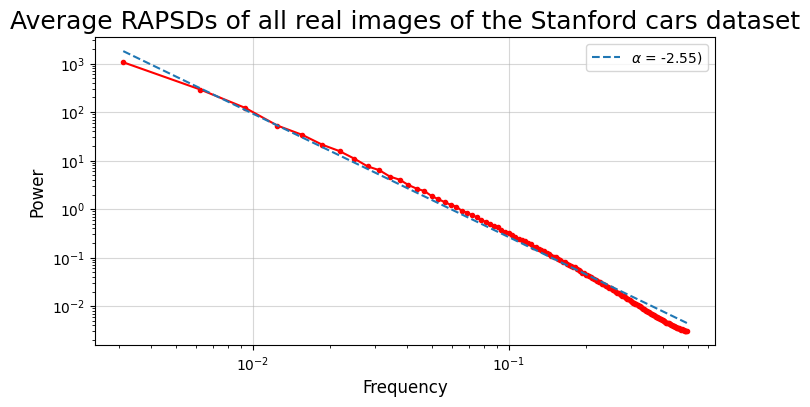

In [ ]:
# Plotting the log RAPSDs
mean_log_rapsd, frequencies = calc_mean_log_rapsd(images[..., 1])

# Getting the alpha exponent of powerlaw
log_frequencies = np.log(frequencies[1:])
equally_spaced_log_frequencies = np.linspace(log_frequencies[0], log_frequencies[-1], 1000)
interpolated_rapsd = np.interp(equally_spaced_log_frequencies, log_frequencies, mean_log_rapsd[1:])

m, b = np.polyfit(equally_spaced_log_frequencies, interpolated_rapsd, 1)
linear_fit = m * equally_spaced_log_frequencies + b

# Residuals
mse = np.mean((linear_fit - interpolated_rapsd)**2)
print(mse)
residuals = np.sqrt(mse)

# Plotting

plt.figure(figsize=(8, 4))
plt.title("Average RAPSDs of all real images of the Stanford cars dataset", fontsize = 18)
plt.plot(frequencies[1:], np.exp(mean_log_rapsd)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies), np.exp(linear_fit), label=f'$\\alpha$ = {m:.2f})', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Power', fontsize = 12);

<ipython-input-20-3e52a21ffb0b>:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-0.001, 0.52)


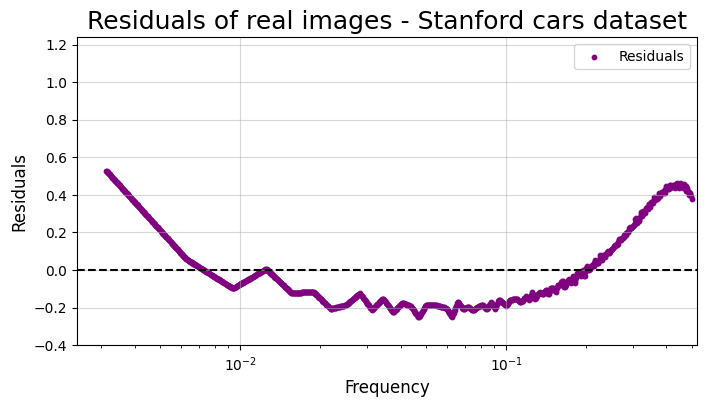

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 4))
residuals = linear_fit - interpolated_rapsd
plt.scatter(np.exp(equally_spaced_log_frequencies), residuals, color='purple', label = "Residuals", s=10)
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Residuals', fontsize = 12)
plt.title("Residuals of real images - Stanford cars dataset", fontsize = 18)
plt.xlim(-0.001, 0.52)
plt.ylim(-0.4,1.24)
plt.legend()
plt.grid(alpha = 0.5)
plt.show()

-----------------

##**Classifying the test images using residuals threshold**

In [ ]:
# Defining path for the zip folder of synthetic images
stanford_cars_synthetic_path = '/content/drive/My Drive/Colab Notebooks/Stanford_Cars/stanford-cars-synthetic-classwise-16.zip'

# Define path we store it in
extraction_path = '/content/stanford-cars-synthetic'

# Extract the zip file to the specified path
with zipfile.ZipFile(stanford_cars_synthetic_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to {extraction_path}")

Files extracted to /content/stanford-cars-synthetic


In [ ]:
all_cars_path = '/content/stanford-cars-synthetic/stanford-cars-synthetic-classwise-16/synthetic_16'

#for car_folder in sorted(os.listdir(all_cars_path)):
#  print(car_folder)

print("We have", len(sorted(os.listdir(all_cars_path))), "models of cars")

We have 197 models of cars


In [ ]:
try:
    # Load the dataset
    dataset_synth_cars = load_dataset(all_cars_path, split="train")
    print("Dataset loaded successfully.")

    # Convert the dataset to a list if it isn't already
    dataset_synth_cars = list(dataset_synth_cars)

    # Shuffle the dataset
    random.seed(42)  # Set seed for reproducibility
    random.shuffle(dataset_synth_cars)

    # Split into train and test sets
    test_set_size = 200
    test_set_fake = dataset_synth_cars[:test_set_size]  # First 200 images
    train_set_fake = dataset_synth_cars[test_set_size:] # Remaining images

    # Print sizes
    print(f"Training set size: {len(train_set_fake)}")
    print(f"Test set size: {len(test_set_fake)}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Resolving data files:   0%|          | 0/3120 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.
Training set size: 2920
Test set size: 200


In [ ]:
# Defining path for the zip folder of real images
stanford_cars_real_path = '/content/drive/My Drive/Colab Notebooks/Stanford_Cars/stanford-cars-real-train-fewshot.zip'

# Define path we store it in
extraction_path = '/content/stanford-cars-real'

# Extract the zip file to the specified path
with zipfile.ZipFile(stanford_cars_real_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Files extracted to {extraction_path}")

Files extracted to /content/stanford-cars-real


In [ ]:
all_real_cars_path = '/content/stanford-cars-real/stanford-cars-real-train-fewshot'

#for car_folder in sorted(os.listdir(all_cars_path)):
#  print(car_folder)

print("We have", len(sorted(os.listdir(all_real_cars_path))), "models of cars")

We have 197 models of cars


In [ ]:
import random
try:
    # Load the dataset
    dataset_real_cars = load_dataset(all_real_cars_path, split="train")
    print("Dataset loaded successfully.")

    # Convert the dataset to a list
    dataset_real_cars = list(dataset_real_cars)

    # Shuffle the dataset
    random.seed(42)  # Set seed
    random.shuffle(dataset_real_cars)

    # Split into train and test sets
    test_set_size = 200
    test_set_real = dataset_real_cars[:test_set_size]  # First 200 images
    train_set_real = dataset_real_cars[test_set_size:] # Remaining images

    # Print sizes
    print(f"Training set size: {len(train_set)}")
    print(f"Test set size: {len(test_set)}")
except Exception as e:
    print(f"Error loading dataset: {e}")

Resolving data files:   0%|          | 0/3136 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.
Error loading dataset: name 'train_set' is not defined


In [ ]:
# Function to resize and crop images
def resize_and_crop(image, image_size):
    # Resize to the given image size and crop (if needed)
    image = cv2.resize(image, (image_size, image_size))
    return image

# Number of examples to extract
image_size = 320
num_examples_fake = len(test_set_fake)
num_examples_real = len(test_set_real)

# Extract and process images for fake images
images_fake = []
for example in itertools.islice(test_set_fake, num_examples_fake):
    # Assuming the 'image' field holds the image data in bytes
    image = example['image']
    image = np.array(image)
    image = resize_and_crop(image, image_size)

    # Check if all images have the same shape
    if images_fake and image.shape != images_fake[0].shape:
        print(f"Skipping image due to inconsistent shape: {image.shape}")
        num_examples_fake -= 1
        continue

    images_fake.append(image)

images_fake = np.array(images_fake)

# Extract and process images for real images
images_real = []
for example in itertools.islice(test_set_real, num_examples_real):
    # Assuming the 'image' field holds the image data in bytes
    image = example['image']
    image = np.array(image)
    image = resize_and_crop(image, image_size)

    # Check if all images have the same shape
    if images_real and image.shape != images_real[0].shape:
        print(f"Skipping image due to inconsistent shape: {image.shape}")
        num_examples_real -= 1
        continue

    images_real.append(image)

images_real = np.array(images_real)

Skipping image due to inconsistent shape: (320, 320)


In [ ]:
# Scale and shift the images to [-1, 1]
images_fake = (images_fake.astype(np.float32) / 255.0) * 2 - 1
images_real = (images_real.astype(np.float32) / 255.0) * 2 - 1

**Classifying the synthetic images**

In [ ]:
fake_images_classification = []

for k in range(num_examples_fake):
    # Compute the RAPSD for the current image
    rapsd, frequencies = spectral.rapsd(images_fake[k, ..., 1], fft_method=np.fft, return_freq=True)

    # Log-transform the RAPSD values
    log_rapsd = np.log(rapsd + 1e-30)

    # Log-transform the frequencies
    log_frequencies = np.log(frequencies[1:])

    # Create equally spaced log frequencies for interpolation
    equally_spaced_log_frequencies = np.linspace(log_frequencies[0], log_frequencies[-1], 1000)

    # Interpolate the log_rapsd to the equally spaced log frequencies
    interpolated_rapsd = np.interp(equally_spaced_log_frequencies, log_frequencies, log_rapsd[1:])

    # Perform linear fitting on the interpolated log_rapsd
    m, b = np.polyfit(equally_spaced_log_frequencies, interpolated_rapsd, 1)
    linear_fit = m * equally_spaced_log_frequencies + b

    residuals = interpolated_rapsd - linear_fit

    min_residual = np.min(residuals)
    max_residual = np.max(residuals)

    # Classify the image based on the residuals
    if max_residual > 0.65:       #min_residual < -0.3 and
        fake_images_classification.append(0)  # Fake image classified as 0
    else:
        fake_images_classification.append(1)  # Real image classified as 1

In [ ]:
(len(fake_images_classification)-sum(fake_images_classification))/len(fake_images_classification)

0.86

**Classifying the real images**

In [ ]:
real_images_classification = []

for k in range(num_examples_real):
    # Compute the RAPSD for the current image
    rapsd, frequencies = spectral.rapsd(images_real[k, ..., 1], fft_method=np.fft, return_freq=True)

    # Log-transform the RAPSD values
    log_rapsd = np.log(rapsd + 1e-30)

    # Log-transform the frequencies
    log_frequencies = np.log(frequencies[1:])

    # Create equally spaced log frequencies for interpolation
    equally_spaced_log_frequencies = np.linspace(log_frequencies[0], log_frequencies[-1], 1000)

    # Interpolate the log_rapsd to the equally spaced log frequencies
    interpolated_rapsd = np.interp(equally_spaced_log_frequencies, log_frequencies, log_rapsd[1:])

    # Perform linear fitting on the interpolated log_rapsd
    m, b = np.polyfit(equally_spaced_log_frequencies, interpolated_rapsd, 1)
    linear_fit = m * equally_spaced_log_frequencies + b

    residuals = interpolated_rapsd - linear_fit

    min_residual = np.min(residuals)
    max_residual = np.max(residuals)

    # Classify the image based on the residuals
    if max_residual > 0.65 :
        real_images_classification.append(0)  # Fake image classified as 0
    else:
        real_images_classification.append(1)  # Real image classified as 1

In [ ]:
sum(real_images_classification)/len(real_images_classification)

0.33668341708542715